In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
df = sns.load_dataset('titanic') # 타이타닉 데이터 받아오기
cols = ["age","sibsp","parch","fare"] # 숫자니까 바로 사용
features = df[cols] # 피쳐
target = df["survived"] # 정답값
# one hot encoding
cols = ["pclass","sex","embarked"] # 범주형
enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
features = pd.concat([features,tmp],axis=1)
# 나이 결측치 채우기
features.age = features.age.fillna(features.age.median())

- 스케일링

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features.loc[:,features.columns] = scaler.fit_transform(features)

In [3]:
features.head()

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,embarked_nan
0,0.271174,0.125,0.0,0.014151,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.472229,0.125,0.0,0.139136,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.321438,0.000,0.0,0.015469,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.434531,0.125,0.0,0.103644,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.434531,0.000,0.0,0.015713,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [4]:
SEED = 42

x_train,x_valid,y_train,y_valid = train_test_split(features,target,random_state=SEED,test_size=0.2)
x_train.shape,x_valid.shape,y_train.shape,y_valid.shape

((712, 13), (179, 13), (712,), (179,))

# 앙상블 학습(Ensemble Learning)
- 기계학습에서 여러개의 개별모델의 예측을 결합함으로써 보다 정확한 예측을 도출하는 기법

# 앙상블 모델

## Random Forest
- 랜덤하게 일부 샘플들과 일부 피쳐들을 뽑아서 여러개의 트리를 만들어서 앙상블하는 모델
- 배깅 방식을 이용
- 배깅(Bagging)
    - Bootstrap Aggregation 의 약어
    - 샘플을 랜덤하게 여러번 뽑아 각 모델에 학습시켜 결과물을 집계 하는 방법

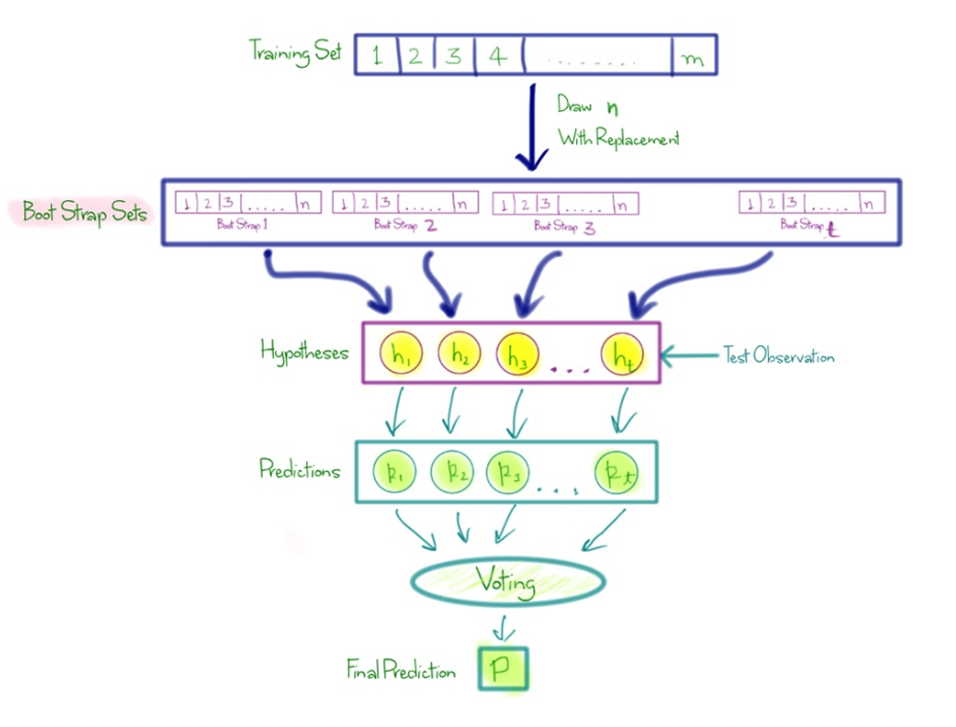

In [5]:
from sklearn.ensemble import RandomForestClassifier

hp = {
    "random_state" : SEED,
    "max_features" : "sqrt", # None 을 줄경우 전체피쳐 사용 
    "n_estimators" : 100, # 트리개수 
    "max_depth" : 10,
    "min_samples_split" : 10,
    "min_samples_leaf" : 3,
}

model = RandomForestClassifier(**hp)
model.fit(x_train,y_train)
pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.8952380952380953

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

hp = {
    "random_state" : SEED,
    "base_estimator" : LogisticRegression(random_state=SEED), # None 이면 결정트리를 사용함
    "n_estimators" : 100, # base_estimator 개수
    "max_features" : 0.5 # 추출할 샘플 비율
}
model = BaggingClassifier(**hp)
model.fit(x_train,y_train)
pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.8698841698841698

## Voting
- 여러 모델들의 예측값을 투표방식(hard) or 평균방식(soft) 으로 앙상블 

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

estimators = [
    ( "mlp" , MLPClassifier(max_iter=1000,random_state=SEED) ),
    ( "lr" , LogisticRegression(random_state=SEED) ),
    ( "rf" , RandomForestClassifier(random_state=SEED) )
]

hp = {
    "estimators" : estimators,
    "voting" : "soft"
}


model = VotingClassifier(**hp)
model.fit(x_train,y_train)
pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.9063063063063064

In [8]:
from sklearn.metrics import f1_score
hp = {
    "estimators" : estimators,
    "voting" : "hard"
}


model = VotingClassifier(**hp)
model.fit(x_train,y_train)
pred = model.predict(x_valid)
f1_score(y_valid,pred)

0.7659574468085106

## Stacking
- 여러 모델들의 예측값을 최종모델(메타모델)의 학습 데이터로 사용해서 예측하는 방법
- 과적합 방지 하기 위해 내부적으로 CV를 진행한다.

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

estimators = [
    ( "knn" , KNeighborsClassifier(n_neighbors=10,weights="distance") ),
    ( "dt" , DecisionTreeClassifier(max_depth=3,random_state=SEED) ),
    ( "rf" , RandomForestClassifier(random_state=SEED) )
]

hp = {
    "estimators" : estimators,
    "final_estimator" : LogisticRegression(random_state=SEED)
}

model = StackingClassifier(**hp,n_jobs=-1)
model.fit(x_train,y_train)
pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.8820463320463321

## GradientBoosting
- 트리기반 부스팅 앙상블 모델
- 머신러닝 알고리즘 중에서 가장 예측 성능이 높다고 알려졌고 인기있는 알고리즘
- Boosting
     - 약한 모델을 결합하여 강한 모델을 만드는 과정
     - 배깅과 다른점은 순차적으로 모델을 만들어 각 모델의 예측결과를 결합

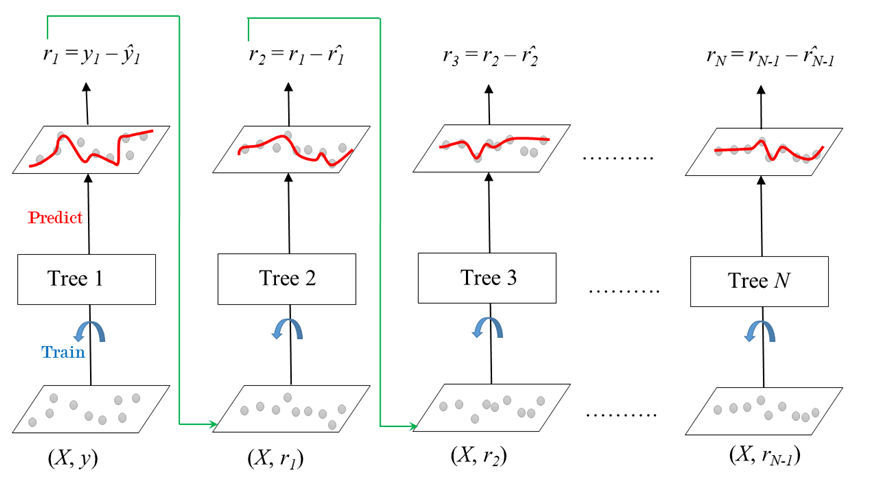

- 데이터 복사 해놓기

In [10]:
data_backup = x_train.copy(), x_valid.copy() , y_train.copy(), y_valid.copy()

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error 

In [12]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
data = diabetes.data
target = diabetes.target
data.shape , target.shape

((442, 10), (442,))

In [13]:
x_train,x_valid,y_train,y_valid = train_test_split(data,target,random_state=SEED)
x_train.shape,x_valid.shape,y_train.shape,y_valid.shape

((331, 10), (111, 10), (331,), (111,))

In [14]:
hp = {
    "max_depth" : 2,
    "random_state" : SEED
}
weak_1 = DecisionTreeRegressor(**hp)
weak_1.fit(x_train,y_train)
pred = weak_1.predict(x_train)

In [15]:
residual = y_train - pred

weak_2 = DecisionTreeRegressor(**hp)
weak_2.fit(x_train,residual)
pred = weak_2.predict(x_train)

In [16]:
residual = residual - pred

weak_3 = DecisionTreeRegressor(**hp)
weak_3.fit(x_train,residual)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [17]:
pred = weak_1.predict(x_valid) + weak_2.predict(x_valid) + weak_3.predict(x_valid)
mean_squared_error(y_valid,pred) ** 0.5 # RMSE

61.872491186086826

In [18]:
hp

{'max_depth': 2, 'random_state': 42}

In [19]:
gbr = GradientBoostingRegressor(max_depth=2,random_state=SEED,n_estimators=3,learning_rate=1.)
gbr.fit(x_train,y_train)
pred = gbr.predict(x_valid)
mean_squared_error(y_valid,pred) ** 0.5

61.872491186086826

- 복사한 타이타닉 데이터 복원하기

In [20]:
x_train, x_valid, y_train, y_valid = data_backup

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

hp = {
    "random_state" : SEED,
    "max_depth" : 2,
    "n_estimators" : 100, # 수행할 부스팅 단계 수
}

model = GradientBoostingClassifier(**hp)
model.fit(x_train,y_train)
pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.8911196911196911

## XGBoost
- 병렬 처리가 불가능한 GBM의 단점을 보완
- GPU 지원
- 내장된 교차검증과 결측치 처리 같은 부가기능도 있다.
- GBM 보다 속도가 향상
- 과적합 방지를 GBM 보다 더 뛰어나게 방지한다.
- https://xgboost.readthedocs.io/en/stable/

In [22]:
from xgboost import XGBClassifier,plot_importance

hp = {
    "random_state" : SEED,
    "max_depth" : 2,
    "n_estimators" : 100, # 수행할 부스팅 단계 수
}

model = XGBClassifier(**hp)
model.fit(x_train,y_train)
pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.8868082368082368

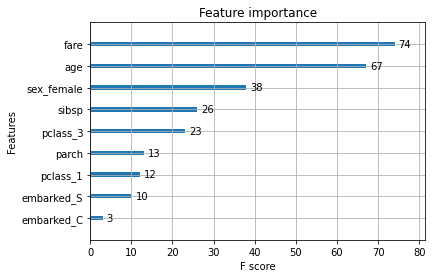

In [23]:
import matplotlib.pyplot as plt
plot_importance(model)
plt.show()

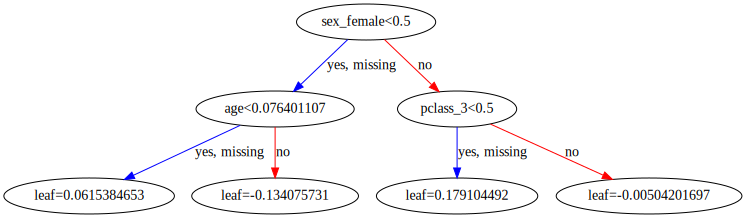

In [24]:
from xgboost import to_graphviz
to_graphviz(model)

## LightGBM
- https://lightgbm.readthedocs.io/en/latest/index.html

- XGBoost 와 마찬가지로 병렬 처리및 GPU 지원
- XGB 보다 학습에 걸리는 시간이 적다
- XGB 보다 메모리를 훨씬 적게 사용

In [25]:
from lightgbm import LGBMClassifier, plot_importance

In [26]:
hp = {
    "random_state" : SEED,
    "max_depth" : 2,
    "n_estimators" : 100, # 수행할 부스팅 단계 수
}

model = LGBMClassifier(**hp)
model.fit(x_train,y_train)
pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.8821106821106821

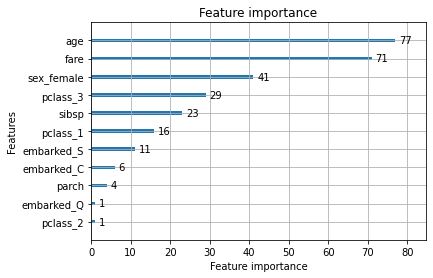

In [27]:
plot_importance(model)
plt.show()

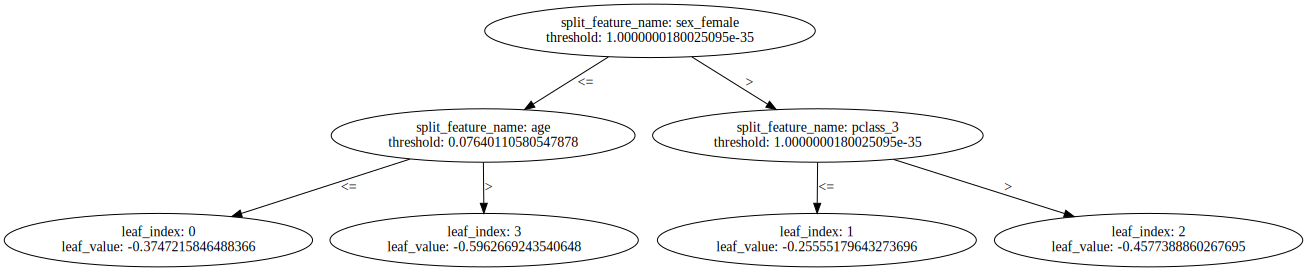

In [28]:
from lightgbm import create_tree_digraph
create_tree_digraph(model)

## catboost
- 범주형 변수에 대하여 강력한 성능을 보여주는 GBM 기반 모델
- 범주형 변수가 많을 경우 높은 성능과 함께 속도가 lightgbm 보다 빠르다.
- 수치형 변수가 많을 경우 매우 느림
- 특징으로 범주형 변수를 인코딩 하지 않고 넣어도 된다.
- https://catboost.ai/en/docs/

In [29]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 78 kB/s 


In [30]:
from catboost import CatBoostClassifier

hp = {
    "random_state" : SEED,
    "max_depth" : 2,
    "n_estimators" : 100, # 수행할 부스팅 단계 수
    "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
}

model = CatBoostClassifier(**hp)
model.fit(x_train,y_train)
pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.8787001287001287